In [1]:
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv1D, MaxPool1D, Dropout, GlobalMaxPool1D, Embedding, Dense, InputLayer, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from matplotlib import pyplot as plt

In [2]:
from IPython import display
import soundfile as sf
from keras.models import load_model


In [3]:
SAMPLING_RATE = 22050

In [4]:
data = tf.keras.utils.audio_dataset_from_directory('./data', seed=7, batch_size=1000)

Found 999 files belonging to 10 classes.


In [5]:
class_names = data.class_names

In [6]:
class_names

['blues',
 'classical',
 'country',
 'disco',
 'hiphop',
 'jazz',
 'metal',
 'pop',
 'reggae',
 'rock']

In [7]:
X = []
y = []

for (x, l) in data.as_numpy_iterator():
    X = x
    y = l

In [17]:
X[0].shape

(675808, 1)

In [18]:
X[0]

array([[-0.0005188 ],
       [ 0.00067139],
       [-0.00146484],
       ...,
       [ 0.        ],
       [ 0.        ],
       [ 0.        ]], dtype=float32)

In [19]:
class_names[y[0]]

'blues'

In [8]:
def play_sound(x):
    sf.write("./preview_data/test_sound.wav",x,SAMPLING_RATE)
    display.display(display.Audio("./preview_data/test_sound.wav"))

In [21]:
play_sound(X[0])

In [9]:
np.bincount(y)

array([100, 100, 100, 100, 100,  99, 100, 100, 100, 100], dtype=int64)

from command above, we can se that dataset contains balanced classes so there is no need for additional processing

In [10]:
np.min(X)

-1.0

In [11]:
np.max(X)

0.9999695

all values are in range [-1,1],  no need for scaling

# Train test validation split

In [12]:
X_train, X_test_val, y_train, y_test_val = train_test_split(X, y, stratify=y, test_size=0.3, random_state=27)
X_test, X_val, y_test, y_val = train_test_split(X_test_val, y_test_val, stratify=y_test_val, test_size=0.6, random_state=27)

In [13]:
X_train.shape

(699, 675808, 1)

In [14]:
X_test.shape

(120, 675808, 1)

In [15]:
X_val.shape

(180, 675808, 1)

# Splitting data
splitting each instance in 5 pices

this step comes after train_test_validation split so the parts of same instance doesn't end up in different subset

In [16]:
def splitting_data(X,y):
    newX = []
    newY = []

    X_len = X[0].shape[0]
    res = X_len%5
  
    n = X.shape[0]

    for i in range(n):
        X_pom = X[i][:-(res)]
        pom = np.split(X_pom,5)
        for j in range(5):
            newX.append(pom[j])
            newY.append(y[i])

    return np.array(newX), np.array(newY)

In [17]:
newX_train, newy_train = splitting_data(X_train,y_train)
newX_test, newy_test = splitting_data(X_test,y_test)
newX_val, newy_val = splitting_data(X_val, y_val)

In [18]:
newX_train.shape

(3495, 135161, 1)

In [19]:
newX_test.shape

(600, 135161, 1)

In [20]:
newX_val.shape

(900, 135161, 1)

In [21]:
newy_train = to_categorical(newy_train)
newy_test = to_categorical(newy_test)
newy_val = to_categorical(newy_val)

In [22]:
newy_test.shape

(600, 10)

preview of sliced data

In [36]:
play_sound(newX_train[2500])

## Training models with different learning rate

In [23]:
EPOCH = 15
BATCH_SIZE = 16
VALIDATION_SPLIT = 0.2
new_input_dim = newX_train[0].shape

In [24]:
#learning = 0.001
model1= Sequential([
    InputLayer(input_shape=new_input_dim),
    Conv1D(32, 5, activation='relu'),
    MaxPool1D(5),
    Dropout(0.3),
    Conv1D(32, 5, activation='relu'),
    MaxPool1D(5),
    Dropout(0.25),
    Conv1D(32, 5, activation='relu'),
    MaxPool1D(5),
    Dropout(0.2),
    Conv1D(32, 5, activation='relu'),
    MaxPool1D(5),
    Dropout(0.1),
    Conv1D(32, 5, activation='relu'),
    MaxPool1D(5),
    Dropout(0.1),
    Conv1D(32, 5, activation='relu'),
    MaxPool1D(5),
    Dropout(0.1),
    Flatten(),
    Dense(10, activation='softmax')
])
model1.summary()
model1.compile(loss=CategoricalCrossentropy(), optimizer=Adam(0.001), metrics=['accuracy'])
history1 = model1.fit(newX_train, newy_train, batch_size=BATCH_SIZE, epochs=EPOCH, validation_split=VALIDATION_SPLIT) 

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 135157, 32)        192       
                                                                 
 max_pooling1d (MaxPooling1  (None, 27031, 32)         0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 27031, 32)         0         
                                                                 
 conv1d_1 (Conv1D)           (None, 27027, 32)         5152      
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 5405, 32)          0         
 g1D)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 5405, 32)          0

In [25]:
model1.evaluate(newX_val,newy_val)

29/29 [==============================] - 11s 382ms/step - loss: 1.1519 - accuracy: 0.6033


[1.1518750190734863, 0.6033333539962769]

In [44]:
model1.save("./1D_Conv_models/model-0.001rate.h5")

C:\Users\spesi\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [27]:
#learning = 0.01
model2 = Sequential([
    InputLayer(input_shape=new_input_dim),
    Conv1D(32, 5, activation='relu'),
    MaxPool1D(5),
    Dropout(0.3),
    Conv1D(32, 5, activation='relu'),
    MaxPool1D(5),
    Dropout(0.25),
    Conv1D(32, 5, activation='relu'),
    MaxPool1D(5),
    Dropout(0.2),
    Conv1D(32, 5, activation='relu'),
    MaxPool1D(5),
    Dropout(0.1),
    Conv1D(32, 5, activation='relu'),
    MaxPool1D(5),
    Dropout(0.1),
    Conv1D(32, 5, activation='relu'),
    MaxPool1D(5),
    Dropout(0.1),
    Flatten(),
    Dense(10, activation='softmax')
])
model2.summary()
model2.compile(loss=CategoricalCrossentropy(), optimizer=Adam(0.01), metrics=['accuracy'])
history2 = model2.fit(newX_train, newy_train, batch_size=BATCH_SIZE, epochs=EPOCH, validation_split=VALIDATION_SPLIT) 

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_6 (Conv1D)           (None, 135157, 32)        192       
                                                                 
 max_pooling1d_6 (MaxPoolin  (None, 27031, 32)         0         
 g1D)                                                            
                                                                 
 dropout_6 (Dropout)         (None, 27031, 32)         0         
                                                                 
 conv1d_7 (Conv1D)           (None, 27027, 32)         5152      
                                                                 
 max_pooling1d_7 (MaxPoolin  (None, 5405, 32)          0         
 g1D)                                                            
                                                                 
 dropout_7 (Dropout)         (None, 5405, 32)         

In [45]:
model2.save("./1D_Conv_models/model-0.01rate.h5")

In [29]:
model2.evaluate(newX_val,newy_val)

29/29 [==============================] - 11s 380ms/step - loss: 2.3055 - accuracy: 0.1000


[2.305549144744873, 0.10000000149011612]

In [30]:
#learning = 0.0001
model3 = Sequential([
    InputLayer(input_shape=new_input_dim),
    Conv1D(32, 5, activation='relu'),
    MaxPool1D(5),
    Dropout(0.3),
    Conv1D(32, 5, activation='relu'),
    MaxPool1D(5),
    Dropout(0.25),
    Conv1D(32, 5, activation='relu'),
    MaxPool1D(5),
    Dropout(0.2),
    Conv1D(32, 5, activation='relu'),
    MaxPool1D(5),
    Dropout(0.1),
    Conv1D(32, 5, activation='relu'),
    MaxPool1D(5),
    Dropout(0.1),
    Conv1D(32, 5, activation='relu'),
    MaxPool1D(5),
    Dropout(0.1),
    Flatten(),
    Dense(10, activation='softmax')
])
model3.summary()
model3.compile(loss=CategoricalCrossentropy(), optimizer=Adam(0.0001), metrics=['accuracy'])
history3 = model3.fit(newX_train, newy_train, batch_size=BATCH_SIZE, epochs=EPOCH, validation_split=VALIDATION_SPLIT) 

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_12 (Conv1D)          (None, 135157, 32)        192       
                                                                 
 max_pooling1d_12 (MaxPooli  (None, 27031, 32)         0         
 ng1D)                                                           
                                                                 
 dropout_12 (Dropout)        (None, 27031, 32)         0         
                                                                 
 conv1d_13 (Conv1D)          (None, 27027, 32)         5152      
                                                                 
 max_pooling1d_13 (MaxPooli  (None, 5405, 32)          0         
 ng1D)                                                           
                                                                 
 dropout_13 (Dropout)        (None, 5405, 32)         

In [46]:
model3.save("./1D_Conv_models/model-0.0001rate.h5")

In [31]:
model3.evaluate(newX_val,newy_val)

29/29 [==============================] - 11s 371ms/step - loss: 1.6975 - accuracy: 0.3989


[1.697493076324463, 0.39888888597488403]

In [60]:
def plot_graphs(history, title):
    plt.subplot(1,2,1)
    plt.title(title+" - accuracy")
    plt.plot(history.epoch,history.history['accuracy'])
    plt.plot(history.epoch,history.history['val_accuracy'])
    plt.legend(['train','val'])

    plt.subplot(2,2,2)
    plt.title(title+" - loss")
    plt.plot(history.epoch,history.history['loss'])
    plt.plot(history.epoch,history.history['val_loss'])
    plt.legend(['train','val'])

    plt.show()

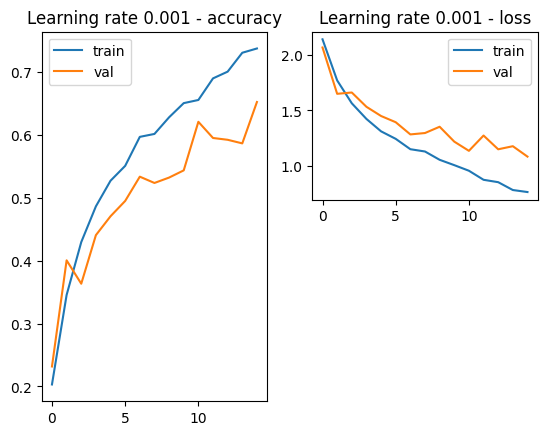

In [61]:
plot_graphs(history=history1, title="Learning rate 0.001")

Difference between train and validation scores are small, so there is no over-fitting and results are good in general.

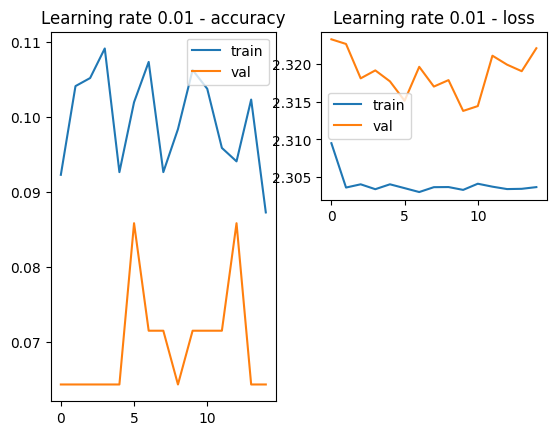

In [63]:
plot_graphs(history=history2, title="Learning rate 0.01")

For this model the difference between train and validation scores is not big, but results in general are bad.

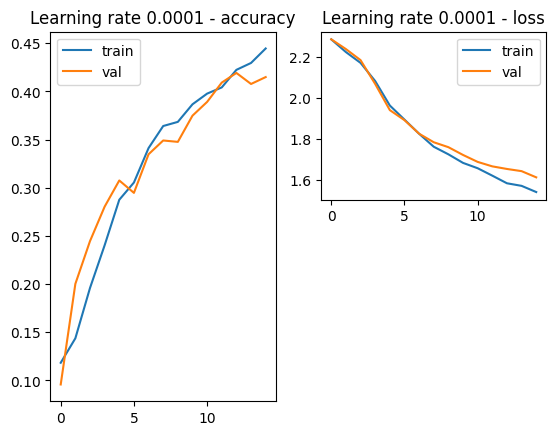

In [64]:
plot_graphs(history=history3, title="Learning rate 0.0001")

Train and Validation line are matching, so there is no over-fitting. The results are better than those of 'model2', but still the accuracy is not better then the 'model1'.

From these plots we can see that the best model is the one with learning rate of 0.001. Further analysis and comparisons are seen in next notebook.